# Randomised Benchmarking

We first generate and queue the circuits we need to execute:

In [1]:
from rlnoise.dataset import CircuitRepresentation

In [2]:
import lmfit as lm
import matplotlib.pyplot as plt
import numpy as np
from qiboconnection.api import API
from qiboconnection.connection import ConnectionConfiguration
from qibo import gates
from qibo.models import Circuit

from clifford_circuits import clifford_circuits, CliffordGate

api = API(ConnectionConfiguration(username = "alejandro.sopena",api_key = "23287d7c-cd0c-4dfd-90d3-9fb506c11dee"))
api.select_device_id(9)

In [4]:
# Define constants
QUBIT = 2
CLIFFORD_GATES = np.arange(1, 200, 20)
NUM_SEEDS = 20
INVERSE = False




rep = CircuitRepresentation("dataset/config.json")

circuits = []
for num_cliffords in CLIFFORD_GATES:
    circs = list(np.load(f"dataset/RB_set_D{num_cliffords}_1Q_len{NUM_SEEDS}.npz", allow_pickle=True)['clean_rep'])
    for i, c in enumerate(circs):
        c = rep.rep_to_circuit(c)
        circs[i] = c
    np.save(f"dataset/RB_set_D{num_cliffords}_1Q_len{NUM_SEEDS}_circs", circs)
    circuits.extend(circs)
    
for circuit in circuits:
    circuit.add(gates.M(0))

def transpiler(circuit,qubit_map):
    c = Circuit(5)
    c.add(circuit.on_qubits(*qubit_map))
    return c

circuits = [transpiler(circuit,[QUBIT]) for circuit in circuits]

circuits_0 = circuits[:100]
circuits_1 = circuits[100:]

In [58]:
len(circuits_0), len(circuits_1)

(100, 100)

In [59]:
# # We queue all the jobs
result_id_0 = api.execute(circuit=circuits_0, nshots=1000)[0]
result_id_1 = api.execute(circuit=circuits_1, nshots=1000)[0]

print(f"The ids of the executed results are: ({result_id_0}, {result_id_1})")

The ids of the executed results are: (10258, 10259)


Once the jobs have been executed, we can use the cells below to get the probabilities:

In [71]:
results_0 = api.get_result(result_id_0)
results_1 = api.get_result(result_id_1)

Your job with id 10258 is completed.
Your job with id 10259 is completed.


In [72]:
results = results_0 + results_1
results = np.reshape(results, (-1, NUM_SEEDS))  # Reshape results

p0 = []
p0_std = []
p1 = []
p1_std = []

for rb_iteration in results:
    # For each iteration of the RB, we calculate the mean of the probabilities of all the seeds
    temp_p0 = []
    temp_p1 = []

    for result in rb_iteration:
        probs = result["probabilities"]
        temp_p0.append(probs["0"])
        temp_p1.append(probs["1"])

    p0.append(np.mean(temp_p0))
    p0_std.append(np.std(temp_p0))
    p1.append(np.mean(temp_p1))
    p1_std.append(np.std(temp_p1))

And now we can fit the results to get the 1Q-gate fidelity:

In [73]:
# Define fitting function
def fit(results):
    """Fit the experiment results."""

    NG = 1.875

    def fit_exponential(x, ln_p, A, B):
        return A * np.exp(-ln_p) ** (x) + B

    fit_mod_i = lm.Model(fit_exponential)
    fit_mod_i.set_param_hint("A", value=(results.min()) - (results.max()), vary=True)  # might need .flatten
    fit_mod_i.set_param_hint("B", value=results.max(), vary=True)  # Values were set with the initial_fit_params_I
    fit_mod_i.set_param_hint("ln_p", value=0.1, vary=True)

    pars_i = fit_mod_i.make_params()

    result_i = fit_mod_i.fit(data=results.flatten(), x=CLIFFORD_GATES, params=pars_i)

    ln_p_i = result_i.params["ln_p"].value
    A_I = result_i.params["A"].value
    B_I = result_i.params["B"].value
    # I_fit = fit_exponential(len(rb_i_x), ln_p_I, A_I, B_I)

    xi = np.linspace(CLIFFORD_GATES[0], CLIFFORD_GATES[-1], 1000).tolist()  # To smooth the fit
    i_fit = [fit_exponential(val, ln_p_i, A_I, B_I) for val in xi]

    p_i = np.exp(-ln_p_i)
    avg_clifford_fidelity = (1 + p_i) / 2
    avg_gate_fidelity = avg_clifford_fidelity ** (1 / NG)

    return i_fit, avg_gate_fidelity, avg_clifford_fidelity, p_i

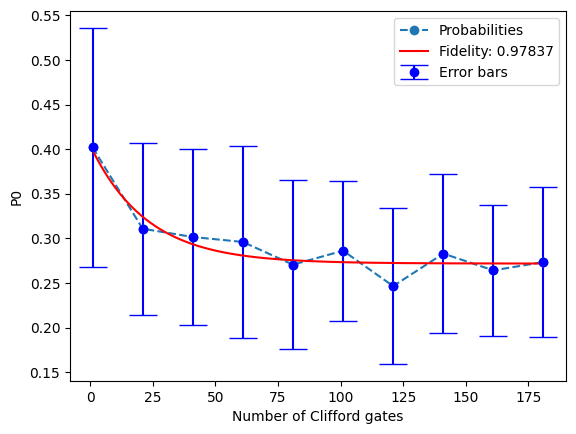

In [74]:
# Fit and plot
I_fit, f_cliff, f_gate, p_i = fit(np.array(p0))

plt.errorbar(CLIFFORD_GATES, p0, yerr=p0_std, capsize=10, fmt="o", color="blue", label="Error bars")
plt.plot(CLIFFORD_GATES, p0, "o--", label="Probabilities")
plt.plot(np.linspace(min(CLIFFORD_GATES), max(CLIFFORD_GATES), 1000), I_fit, "r", label=f"Fidelity: {f_gate:.5f}")
plt.xlabel("Number of Clifford gates")
plt.ylabel("P0")
plt.legend()
plt.show()

In [75]:
print(f_cliff, f_gate, p_i)

0.9884077880246726 0.9783748890481752 0.9567497780963502


In [77]:
data = np.array([[f_cliff, f_gate, p_i], CLIFFORD_GATES, p0, p0_std, p1, p1_std, I_fit], object)
np.save(f"dataset/RB_decay_qubit{QUBIT}.npy", data)

In [78]:
np.load(f"dataset/RB_decay_qubit2.npy", allow_pickle=True)[0]

[0.9884077880246726, 0.9783748890481752, 0.9567497780963502]